## Que 1. How many fatal log entries in the month of December resulted from an ”invalid or missing program image”?

basic steps followed to answer the questions were reffered from
https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html

In [1]:
# importing necessary libraries and datatypes

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, TimestampType, IntegerType
from pyspark.sql.functions import *
import time
import matplotlib.pyplot as plt
import pandas as pd

#setting up a spark session

session = SparkSession.builder.appName("BGLlog").getOrCreate()

23/08/07 18:24:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# start time of the program
start_program_time= time.time()

# Schema Design

In [3]:
# defined the schema for the BGL log data

BGL_schema = StructType([

    StructField("AlertFlag", StringType(),True),
    
    # first Timestamp is assigned to IntegerType datatype and later to TimestampType datatype, 
    # as initializing Timestamp to "TimestampType" datatype in the beginning was not possible
    StructField("Timestamp", IntegerType(),True), 

    StructField("Date", StringType(),True),

    StructField("Node", StringType(),True),

    StructField("date_and_time", TimestampType(),True),

    StructField("Node_Rep", StringType(),True),

    StructField("Message_Type", StringType(),True),

    StructField("SysComp", StringType(),True),

    StructField("Level", StringType(),True),

    StructField("Message_Content", StringType(),True)

])

In [4]:
# read the BGL log data from the CSV file with the specified schema (i.e. BGL_schema) 
# and date/timestamp formats are specified

BGL_df=session.read.csv(
    "BGLnew.log",
    schema = BGL_schema,
    dateFormat = "yyyy.MM.dd", 
    timestampFormat = "yyyy-MM-dd-HH.mm.ss.SSSSSS", 
    )

In [5]:
# cast the Timestamp coloumn to proper TimestampType 

BGL_df = BGL_df.withColumn("Timestamp", BGL_df["Timestamp"].cast(TimestampType()))

In [6]:
# print the schema to confirm the schema update of the Dataframe

BGL_df.printSchema()

root
 |-- AlertFlag: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: string (nullable = true)
 |-- Node: string (nullable = true)
 |-- date_and_time: timestamp (nullable = true)
 |-- Node_Rep: string (nullable = true)
 |-- Message_Type: string (nullable = true)
 |-- SysComp: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Message_Content: string (nullable = true)



# Transformation on BGL dataframe

Here the data log is filtered using the PySpark functionality 'filter()' to filter the data from coloumn by specifying the content that need to be filtered out from the coloumn using 'contain()' functionality of PySpark

In [7]:
# filter the Dataframe to get fatal log entries that occurred in December

fatal_logs_december = BGL_df.filter((col("Level") == "FATAL") & (col("Date").contains(".12.")))

Further filrteration is done using a specific message content "invalid or missing program image" to filter out the dataframe using the same functionality of PySpark

In [8]:
# filter the DataFrame further to get fatal log entries with a specific message content i.e.
# "invalid or missing program image"

invalid_program_image_fatal_logs_december = fatal_logs_december.filter(col("Message_Content").contains(
    "invalid or missing program image"))

In [9]:
# filter the dataframe to remove rows where the "Node" column is either "NULL" or "UNKNOWN_LOCATION"
filtered_df = invalid_program_image_fatal_logs_december.filter((col("Node") != "NULL") & (col("Node") != "UNKNOWN_LOCATION"))

In [10]:
# group the dataframe by "Node" and count the occurrences of each node
node_frequency = filtered_df.groupBy("Node").count()

In [11]:
# order the nodes by the count of occurrences in descending order and get the top 20 nodes
top_20_nodes = node_frequency.orderBy(col("count").desc()).limit(20)

In [12]:
# convert the result to a Pandas dataframe for plotting
top_20_nodes_pandas = top_20_nodes.toPandas()

# Action on the filtered dataframe

To get the number of fatal log entries in the month of December resulted from an ”invalid or missing program image”, 'count()' functionality of PySpark is used.

In [13]:
# count the number of fatal log entries in December with an invalid or missing program image

num_fatal_logs_invalid_image_december = invalid_program_image_fatal_logs_december.count()

In [14]:
# print the result

print("Number of fatal log entries in December with an invalid or missing program image:", num_fatal_logs_invalid_image_december)

Number of fatal log entries in December with an invalid or missing program image: 18584


Running the above execution gives the result for "number of fatal log entries in December with an invalid or missing program image", upon which further analysis is done to show a visualized graph which represents the top 20 nodes that resulted in fatal log entries in December with an invalid or missing program image. This further analysis will help to find the perticular nodes with fatal error.

In [15]:
# show the top 20 nodes in tabular format fatal log entries in December with an invalid or missing program image
top_20_nodes.show()

+-------------------+-----+
|               Node|count|
+-------------------+-----+
|R31-M0-NC-I:J18-U01|   28|
|R31-M0-N0-I:J18-U01|   28|
|R31-M0-N0-I:J18-U11|   28|
|R31-M0-N8-I:J18-U11|   28|
|R31-M0-N8-I:J18-U01|   28|
|R31-M0-N4-I:J18-U01|   28|
|R31-M0-NC-I:J18-U11|   28|
|R31-M0-N4-I:J18-U11|   28|
|R25-M1-N4-I:J18-U11|   27|
|R36-M0-NC-I:J18-U11|   27|
|R13-M1-N0-I:J18-U11|   27|
|R32-M1-N4-I:J18-U11|   27|
|R05-M1-N4-I:J18-U11|   27|
|R03-M1-N4-I:J18-U01|   27|
|R37-M0-N0-I:J18-U11|   27|
|R23-M0-N8-I:J18-U01|   27|
|R20-M0-N0-I:J18-U01|   27|
|R03-M0-N8-I:J18-U01|   27|
|R13-M0-N4-I:J18-U01|   27|
|R27-M0-NC-I:J18-U01|   27|
+-------------------+-----+



basic steps followed to visualize the further analysis on the nodes were reffered from https://sparkbyexamples.com/pandas/plot-the-dataframe-in-a-bar-in-pandas/

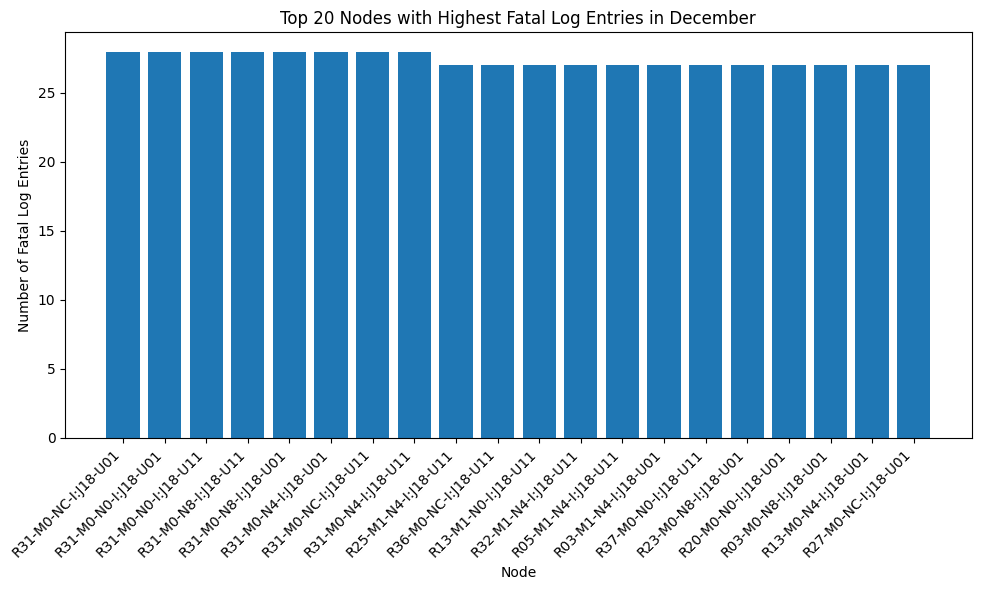

In [16]:
# plot the graph for the top 20 nodes that resulted in 
plt.figure(figsize=(10, 6))
plt.bar(top_20_nodes_pandas["Node"], top_20_nodes_pandas["count"])
plt.xlabel("Node")
plt.ylabel("Number of Fatal Log Entries")
plt.title("Top 20 Nodes with Highest Fatal Log Entries in December")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Execution Time of the Program

To calculate the execution time of a program, import the time module and utilize its functionality. Subtracting the program's start time from the end time will give us the execution time of the program.

In [17]:
# end time of the program
end_program_time= time.time()

# calculate executation time
end_program_time-start_program_time

11.56226396560669

In [18]:
spark